# Categorical environmental descriptors
# Mapping water extent from Landsat sensor data <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Sandbox` environment
* **Products used:** 
[ga_s2am_ard_3](https://explorer.dea.ga.gov.au/products/ga_s2am_ard_3)

## Landsat sensor data.
In this notebook, you are able to interrogate the time-series from on **01 March 1984** to **05 June 2013** to determine the extent of water, which is an environmental descriptor that is categorical. 

To map water, you will be using the [Modified Normalised Difference Water Index (MNDWI)](https://www.nv5geospatialsoftware.com/docs/backgroundotherindices.html).  which can indicate the presence of water, with this defined as:

$$
\begin{aligned}
\text{MNDWI} & = \frac{(\text{Green} - \text{SWIR})}{(\text{Green} + \text{SWIR})}, \\
\end{aligned}
$$

where $\text{SWIR}$ is the shortwave infrared (note that this is often referred to as SWIR-1 in Landsat), and $\text{Green}$ is the green band.
The **MNDWI** values range from -1 to 1 with positive values indicating water.





## Description

The notebook demonstrates how to:

1. Load Landsat sensor data over the water body of interest
2. Calculate the MNDWI
3. Resample the time-series of MNDWI to seasonal medians
4. Animate the water extent time-series
5. Calculate and plot a time series of seasonal water extent (in km<sup>2</sup>)
6. Determine and display the minimum and maximum water extents in the time-series.
7. Compare maps of water extent between two time-periods.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
The cell below imports Python packages that are used for the analysis.
`%matplotlib inline` ensures figures are plot correctly in the Jupyter notebook.
The following commands import various functionality: 

* `sys` provides access to helpful support functions in the `dea_plotting` module. 
* `datacube` provides the ability to query and load data.
* `matplotlib` provides the ability to format and manipulate plots.

In [13]:
%matplotlib inline

import sys
import pystac_client
import odc.stac

from odc.geo import BoundingBox
from odc.geo.cog import write_cog
from odc.geo.xr import assign_crs

import matplotlib.pyplot as plt

from dea_tools.plotting import display_map, rgb

## Connect to DEA's STAC API
This allows us to search for data using DEA's STAC API (refer to the SpatioTemporal Asset Catalogue guide for details).

To load data, we must also configure access to DEA's Amazon S3 buckets using `odc.stac.configure_s3_access`. If launching a Dask client with `dea_tools.dask.create_local_dask_cluster()`, this is done automatically.

In [14]:
# Configure data access
odc.stac.configure_s3_access(cloud_defaults=True, aws_unsigned=True)

# Connect to STAC API
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

### Define your area and time-period of interest

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over. 

To load a different area, you can provide your own `central_lat` and `central_lon` values.
One way to source these is to Google a location, or click directly on the map in [Google Maps](https://www.google.com/maps/@-43.4539764,146.5660989,11642m/data=!3m1!1e3).

The parameters are:

* `lat`: The central latitude to analyse (e.g. -35.0958).
* `lon` : The central longitude to analyse (e.g. 149.4249).
* `lat_buffer` : The number of degrees to load around the central latitude.
* `lon_buffer` : The number of degrees to load around the central longitude.
* `start_year` and `end_year`: The date range to analyse (e.g. `('2017', '2020')`.


**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

The area selected is Lake George near Canberra, Australia, but you can chose anywhere in Australia.  


## A note on Lake George
Lake George located about 40 km away from Canberra, Australia, with the coordinates of:

Central latitude = -35.0958  
Central longitude = 149.4249

The Lake is part of an endorheic basin, meaning it has no outflow of water to rivers or the ocean, and has a unique hydrological dynamics. Water enters the lake through rainfall and runoff, but it either evaporates or seeps into the ground, which makes the lake highly susceptible to changes in weather conditions.

The lake is **episodic** in nature with water levels varying dramatically over time. The lake can be completely dry for years but in other periods, can hold significant volumes of water. This fluctuation depends heavily on the balance between rainfall, evaporation, and groundwater seepage. During wet periods, especially after prolonged rainfall, water can accumulate in the lake, sometimes covering an extensive area. However, due to high evaporation rates and the porous nature of the surrounding soil, water levels can drop rapidly, even after substantial inflows. **Groundwater interactions** play a significant role in the lake's hydrology. Water can seep into the ground from the lakebed, replenishing the surrounding aquifers. In turn, groundwater levels around the lake can also affect its water levels.

### Define the area of interest

In [15]:
# Set the central latitude and longitude
central_lat = -35.0958
central_lon = 149.4249

# Set the buffer to load around the central coordinates
buffer = 0.1


## View the area of Interest on an interactive map
After choosing the study area, it can be useful to visualise it on an interactive map.

> **Note**: The interactive map also returns latitude and longitude values when clicked.
You can use this to generate new latitude and longitude values to try without leaving the notebook.

The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [16]:
# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat)

## Load cloud-masked satellite data
The code below will create a query dictionary for our region of interest, and then load the Landsat satellite data for the area and period of interest.


In [36]:
# Set the data source
# Note the time-periods below.  
product = "ga_ls5t_ard_3"
# product = "ga_ls7t_ard_3"

# Set the date range to load data over.
# Note that Landsat-5 Thematic Mapper (TM) was launched by the United States 
# Geological Survey (USGS) on **01 Mar 1984** and was decommissioned on **05 Jun 2013**.
time = ("2010-03-01", "2013-06-05")
# time = ("2015-03-01", "2020-06-05")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
measurements = [
 #   "nbart_red",
 #   "nbart_blue",
    "nbart_green",
 #   "nbart_nir",
    "nbart_swir_1",   
]

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
crs = "epsg:3577"
resolution = 30

In [37]:
#set up a bounding box for our stac query 
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs=crs
)
bbox_query = bbox.bbox

# Search the catalog for matching S2 data
query = catalog.search(
    bbox=bbox_query,
    collections=[product],
    datetime=time
)

items = list(query.items()) #convert to list
print(f"Found: {len(items):d} datasets")

Found: 49 datasets


In [38]:
#now load the data with odc-stac
ds = odc.stac.load(
    items, #stac items
    bands=measurements, #bands of data to load
    crs=crs,
    resolution=resolution,
    cloud_mask="fmask",  # Use the Fmask for cloud masking
    min_gooddata=0.9,
    groupby="solar_day",
    bbox=bbox, #area to load over
)

## Calculate the MNDWI
The following allows you to calculate the MNDWI and integrate within the Landsat data stack.   

In [39]:
# Calculate the MNDWI index manually
ds['MNDWI'] = (ds['nbart_green'] - ds['nbart_swir_1']) / (ds['nbart_green'] + ds['nbart_swir_1'])
print("MNDWI calculation completed")

MNDWI calculation completed


### View the contents of the new dataset
Note that the dataset includes the green and shortwave infrared bands as well as the MNDWI.

In [40]:
# View the contents of the new dataset
print("MNDWI calculation completed. New dataset:")
ds

MNDWI calculation completed. New dataset:


<xarray.Dataset> Size: 241MB
Dimensions:       (y: 818, x: 702, time: 35)
Coordinates:
  * y             (y) float64 7kB -3.928e+06 -3.928e+06 ... -3.953e+06
  * x             (x) float64 6kB 1.569e+06 1.569e+06 ... 1.59e+06 1.59e+06
    spatial_ref   int32 4B 3577
  * time          (time) datetime64[ns] 280B 2010-03-25T23:41:14.433013 ... 2...
Data variables:
    nbart_green   (time, y, x) float32 80MB 645.0 591.0 587.0 ... nan nan nan
    nbart_swir_1  (time, y, x) float32 80MB 2.431e+03 2.169e+03 ... nan nan
    MNDWI         (time, y, x) float32 80MB -0.5806 -0.5717 -0.5766 ... nan nan

## Resample time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the fmask layer) the data will be gappy and noisy. Here, we will resample the data to ensure we working with a consistent time-series.

To do this we resample the data to seasonal time-steps using medians

These calculations will take several minutes to complete as we will run `.compute()`, triggering all the tasks we scheduled above and bringing the arrays into memory.

In the following cell, you will resample the time-series of MNDWI values to seasonal medians covering each quarter starting in December (i.e., three months) using QS-DEC.  Another option is:   

YE-JAN: Yearly data starting in July.  

However, by using a yearly option, you will not capture the seasonal (within-year) water dynamics.


Calculating MNDWI based on medians...


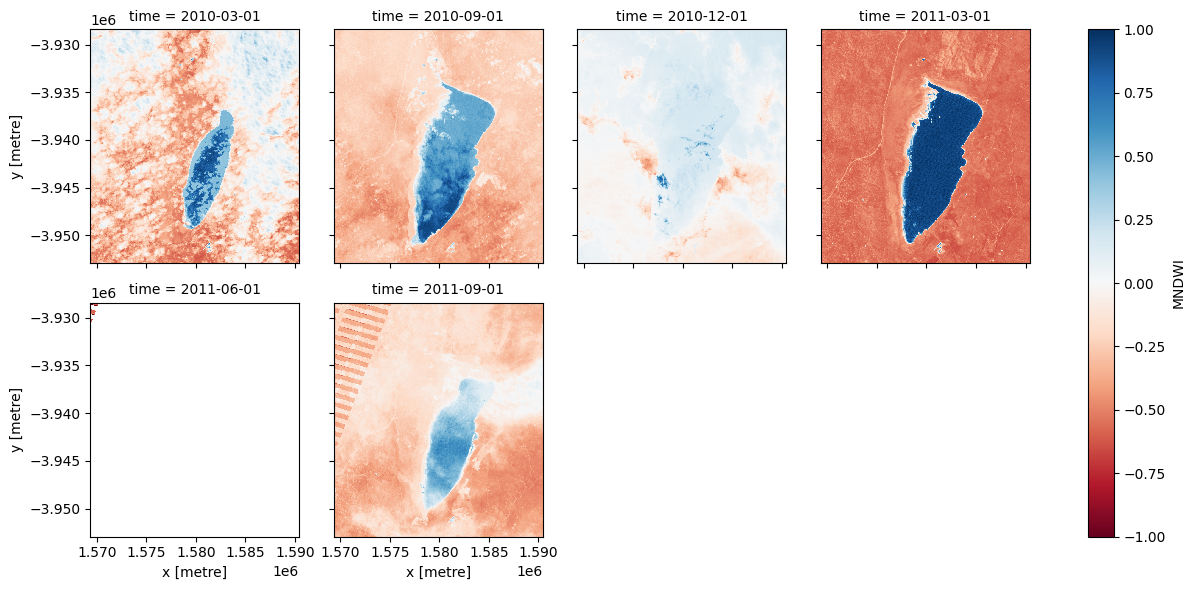

In [41]:
# Start measuring execution time
#%%time
sample_frequency = "QS-DEC"  # quarterly starting in DEC, i.e. seasonal

print("Calculating MNDWI based on medians...")
mndwi = ds["MNDWI"].resample(time=sample_frequency).median().compute()

# Drop any all-NA seasons
mndwi = mndwi.dropna(dim="time", how="all")

# Visualize the results
mndwi.plot.imshow(col="time", col_wrap=4, cmap="RdBu", vmax=1, vmin=-1);

### Export the images
You can export the images to a geotiff and download. In the cell below, you can export a single image.

In [42]:
# Import
import os
import xarray as xr
import rioxarray

# Create directory if it doesn't exist
export_dir = "exported_image/"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

# Select a specific time step, e.g., the first time-step (index 0)
time_step = mndwi.time[0]  # Change index to select the desired time-step, e.g., mndwi.time[5] for the 6th one

# Select the data for the chosen time-step
single_time_slice = mndwi.sel(time=time_step)

# Generate a file name based on the selected time-step
output_filename = f"{export_dir}mndwi_{str(time_step.dt.strftime('%Y%m%d').item())}.tif"

# Export the selected time-step as a COG using rioxarray
single_time_slice.rio.to_raster(
    output_filename,
    driver="COG",  # Specify COG format
    compress="deflate"  # Optional: Use compression to reduce file size
)

print(f"Exported: {output_filename}")

Exported: exported_image/mndwi_20100301.tif


### Export a specific date
For a specific date (e.g., 1st March 2011), you can use the following:

In [43]:
# Import
import pandas as pd

# Create directory if it doesn't exist
export_dir = "exported_image_date/"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

# Specify the actual date you want to export (e.g., '2023-01-01')
specific_date = "2011-03-01"  # Replace with the desired date
specific_date = pd.to_datetime(specific_date)  # Convert to datetime object if it's a string

# Select the data for the specific date
single_time_slice = mndwi.sel(time=specific_date, method="nearest")  # Use 'nearest' to handle cases where the exact date might not exist

# Generate a file name based on the selected date
output_filename = f"{export_dir}mndwi_{str(specific_date.strftime('%Y%m%d'))}.tif"

# Export the selected time-step as a COG using rioxarray
single_time_slice.rio.to_raster(
    output_filename,
    driver="COG",  # Specify COG format
    compress="deflate"  # Optional: Use compression to reduce file size
)

print(f"Exported: {output_filename}")

Exported: exported_image_date/mndwi_20110301.tif


### Exporting the entire time-series.
You can export the full time-series using the code below.

**WARNING**:  This may take up space and is not recommended unless necessary. 
If you do want to run and view the datasets (e.g., in QGIS), then make sure you delete after you have done so:

In [44]:
# Create directory if it doesn't exist
export_dir = "exported_images/"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

# Loop over each time step in the dataset
for i, time_step in enumerate(mndwi.time):
    # Select data for the current time-step
    single_time_slice = mndwi.sel(time=time_step)

    # Generate file name based on the time-step
    output_filename = f"{export_dir}mndwi_{str(time_step.dt.strftime('%Y%m%d').item())}.tif"

    # Export the data using rioxarray
    single_time_slice.rio.to_raster(
        output_filename,
        driver="COG",  # Specify COG format
        compress="deflate"  # Optional: Use compression to reduce file size
    )

    print(f"Exported: {output_filename}")

Exported: exported_images/mndwi_20100301.tif
Exported: exported_images/mndwi_20100901.tif
Exported: exported_images/mndwi_20101201.tif
Exported: exported_images/mndwi_20110301.tif
Exported: exported_images/mndwi_20110601.tif
Exported: exported_images/mndwi_20110901.tif


## Animating time series
In the next cell, we plot the dataset we loaded above as an animation GIF, using the [xr_animation](../How_to_guides/Animated_timeseries.ipynb) function.
The `output_path` will be saved in the directory where the script is found and you can change the names to prevent files overwrite.

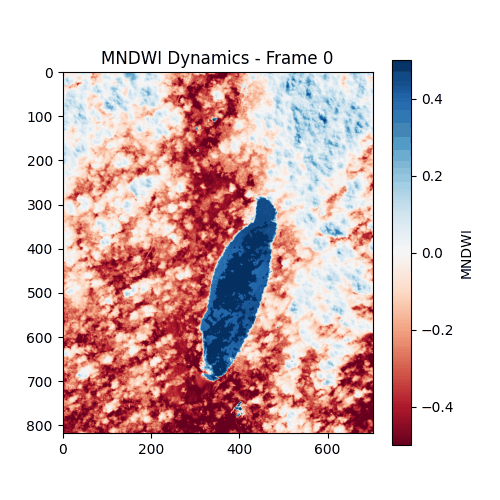

In [45]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

# Convert your mndwi to a dataset (already done)
mndwi_ds = mndwi.to_dataset(name="MNDWI")

# Create figure
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(mndwi_ds.MNDWI.isel(time=0),
               cmap="RdBu", vmin=-0.5, vmax=0.5)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("MNDWI")

def update(i):
    im.set_array(mndwi_ds.MNDWI.isel(time=i))
    ax.set_title(f"MNDWI Dynamics - Frame {i}")
    return [im]

anim = FuncAnimation(fig, update, frames=len(mndwi_ds.time),
                     interval=500, blit=True)

# Save to GIF
out_path = "water_extent.gif"
anim.save(out_path, writer=PillowWriter(fps=2))

plt.close()
Image(filename=out_path)

### Calculate the area per pixel
The Landsat TM data are nominally 25 m x 25 m.  The number of pixels can therefore used for the area of the waterbody.
Run the following cell to generate the necessary constants for performing this conversion.

$$
\begin{aligned}
\text{Area} & = \frac{(\text{Pixel length^2})}{(\text{m per km^2})}, \\
\end{aligned}
$$


In [46]:

m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = resolution**2 / m_per_km**2

### Calculating the extent of water

Calculates the area of pixels where the MNDWI is > 0, which is a threshold used to determine water extent.

In [47]:
# Import
import numpy as np

water = mndwi.where(mndwi > 0)
area_ds = water.where(np.isnan(water), 1)
ds_valid_water_area = area_ds.sum(dim=["x", "y"]) * area_per_pixel

### Plot seasonal time series from the `Start year` to `End year`
View the changes in water over the summary period length (e.g., quarters, years)

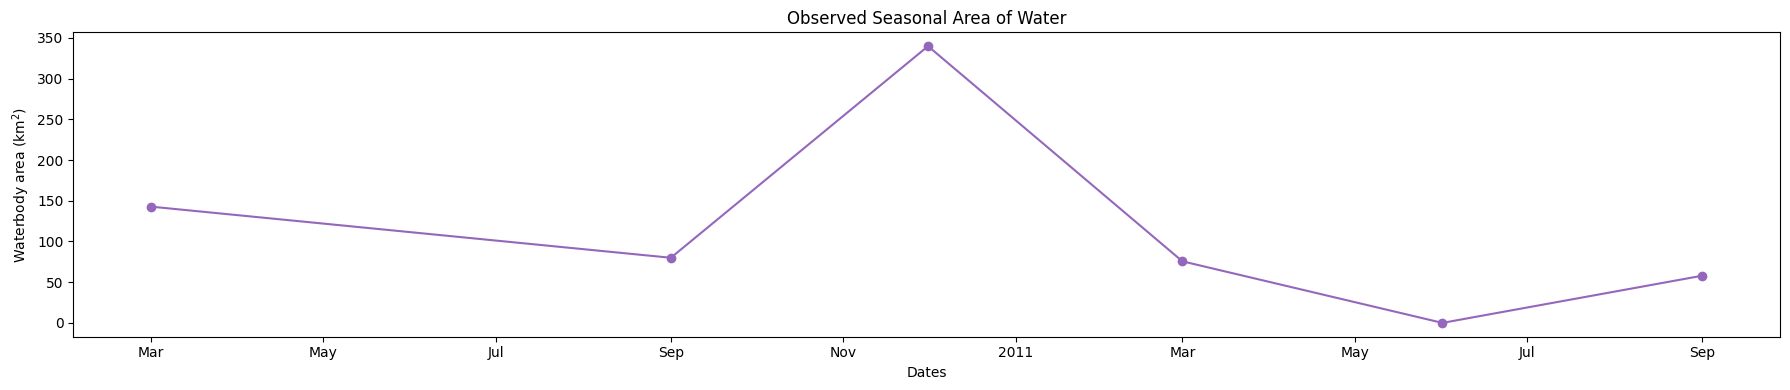

In [48]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker="o", color="#9467bd")
plt.title(f"Observed Seasonal Area of Water")
plt.xlabel("Dates")
plt.ylabel("Waterbody area (km$^2$)")
plt.tight_layout()

## Next steps

You can select a different area and also change the time periods and time steps (e.g., seasonal, annual). Experiment with the different thresholds of the MNDVI and als

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2024

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->